In [1]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2
import FwtModels.AeroModels as ams

### Define the problem

In [2]:
# want to create a model with some fixed parameters

# create the variables
p = dof2.FwtParameters.Default2DoF() # parameter container

mass_ratio = 4                    # mass ratio between wing and FWT
p.m_w = dof2.FwtVariable(4,'m_w')   # mass of inner wing
wing_freq = 2                       # freq of inner wing

# set values for independent symbols
p.s.value = 1
p.c.value = 0.15
p.g.value = 9.81
p.rho.value = 1.225
p.a_t.value = 2 * np.pi
p.alpha_r.value = np.deg2rad(5)
p.Lambda.value = np.deg2rad(-10)

# set expression for dependent symbols
p.k = (sym.Integer(wing_freq)*2*sym.pi)**2*(p.m_w+p.m_w/sym.Float(mass_ratio))
p.m = p.m_w/sym.Integer(mass_ratio)
p.I_xx = sym.Rational(1,12)*p.m*p.s**2*1
p.l = p.s*sym.Rational(2,4)

# potential Energy
half = sym.Rational(1,2)
U = p.m*p.g*(-p.l*sym.cos(p.q[0])) + half*p.k*(p.q[1])**2

# Create Point masses

# Transform for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,p.q[1])
fwt_frame = wing_frame.R_x(-sym.pi*sym.Rational(1,2)+p.q[0])
fwt_com_frame = fwt_frame.Translate(0,p.l,0)
rot = sym.Matrix([-sym.pi*sym.Rational(1,2)+p.q[0],0,0])


mw = dof2.RigidElement.PointMass(wing_frame,sym.Matrix([0,0,0]),p.m_w)


M_fwt = dof2.MassMatrix(p.m,I_xx = p.I_xx)

m = dof2.RigidElement(fwt_com_frame,rot,M_fwt)


# Aero Forces
AeroForces = ams.SimpleAeroModel(p,fwt_frame,at_mode=1)
me.mechanics_printing()


sm = dof2.SymbolicModel(U,[mw,m],p,ExtForces = AeroForces)

### Determine the fixed points of this system

In [3]:
#make alternative dataset
from scipy.optimize import minimize
vs = np.linspace(0,80,101)
aoa = [0,2.5,5,7.5,10]

df = pd.DataFrame(columns=['v','aoa','eta','q1'])

def ToMinimise(x):
    val = sm.deriv(0,[x[0],0,x[1],0],p)
    return val[1]**2 + val[3]**2
    

for i in aoa:
    p.alpha_r.value = np.deg2rad(i)    
    guess = [0,0]
    for v in vs:
        p.V.value = v
        guess = minimize(ToMinimise,guess).x
        df = df.append({'aoa' : i, 'v' : v,'eta':guess[0],'q1':guess[1]} , ignore_index=True)

df[r'$\eta [Deg]$']= np.rad2deg(df['eta'])

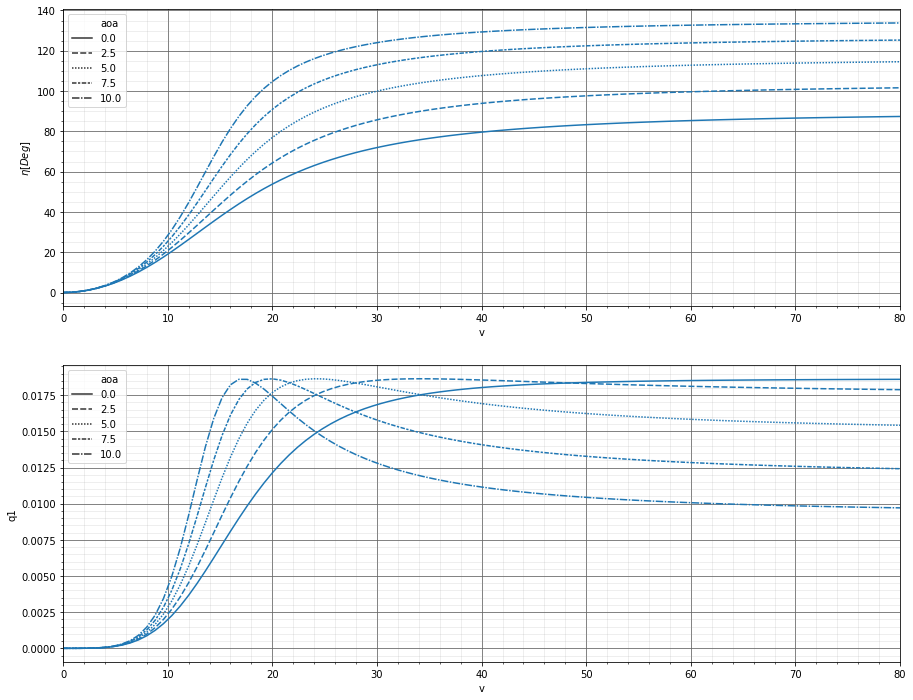

In [4]:
# plot the data
fig, axes = plt.subplots(2,1,figsize=(15,12))
df[r'$\eta [Deg]$']= np.rad2deg(df['eta'])
sns.lineplot(data=df,y=r'$\eta [Deg]$',x='v',style='aoa',ax=axes[0])
axes[0].set(xlim=(0,80))

sns.lineplot(data=df,y='q1',x='v',style='aoa',ax=axes[1])

for ax in axes:
    ax.set(xlim=(0,80))
    ax.grid(b=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

### Linearise the system about some fixed points

In [5]:
# create complete EoM
func = dof2.LinearEoM_func(sm,p,AeroForces,ignore=[p.V,p.alpha_r])

In [9]:
dat = df

flutdfv2 = pd.DataFrame()
for a in dat['aoa'].unique():
    #get relevent data points
    data = dat[(dat['aoa']==a) & (dat['v']<60) & (dat['v']>0)]
    for i in range(0,len(data)):
        # get the static position
        lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]
        # get the jacobian evaluated at this point
        j_lp = func(data['v'].iloc[i],np.deg2rad(a),lp)
        # get eigen values of this jacobian       
        evals,evecs = np.linalg.eig(j_lp)
        
        # get unique modes
        e_vals_unique_imag = []
        e_vals_unique_real = []
        mode = []
        for j in evals:
            if np.imag(j)!=0:
                if np.abs(np.imag(j)) not in np.imag(e_vals_unique_imag):
                    e_vals_unique_imag.append(np.abs(np.imag(j)))
                    e_vals_unique_real.append(np.real(j))
                    mode.append(len(mode))
        if np.max(e_vals_unique_real)<0:
            df_v = pd.DataFrame()
            df_v['Mode'] = mode
            df_v['cn'] = np.array(e_vals_unique_real) + 1j * np.array(e_vals_unique_imag)
            df_v['Frequency'] = np.abs(df_v['cn'])/(2*np.pi)
            df_v['Damping'] = np.cos(np.angle(df_v['cn']))
            df_v['V'] = data['v'].iloc[i]
            df_v['aoa'] = a
            flutdfv2 = flutdfv2.append(df_v,sort=False)
        

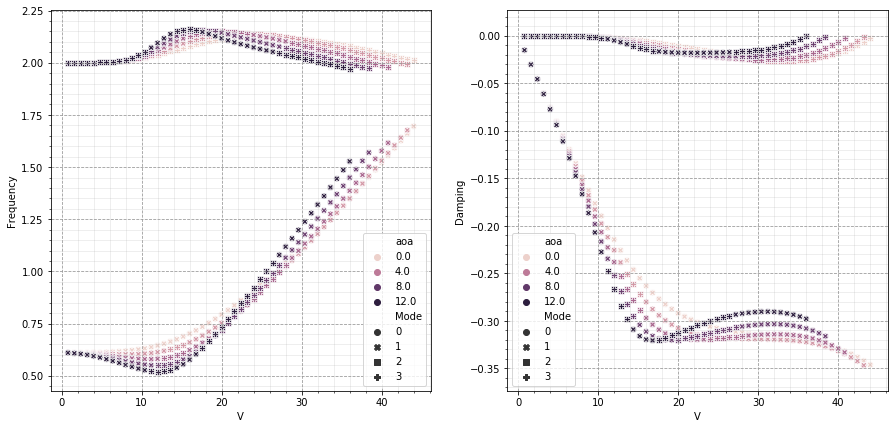

In [10]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
data = flutdfv2[(flutdfv2['Damping']<0)]
#data = flutdfv2
fig, axes = plt.subplots(1,2,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='aoa',style='Mode',ax=axes[0])
sns.scatterplot(data=data,x='V',y='Damping',hue='aoa',style='Mode',ax=axes[1])
for i in [0,1]:
    #axes[i].set(xlim=(0,80))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)